# Deep diving into USAID health comodity delivery dataset

### Read and load the CSV file to the system

In [1]:
import pandas as pd

# Path to your CSV file
csv_file_path = 'USAID_Health_Comodity_Delivery.csv'

# Read the CSV file
df = pd.read_csv(csv_file_path)



/tmp/ipykernel_4127/3039883906.py:7: DtypeWarning: Columns (74,75,76,88) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)


### Filter out 2 dataframes: one for COVID-19 and the other for more or less normal operation:

- Defining these boundaries is challenging. USAID only sends supplies to nations with complex political issues, so there might be a war or other conflicts. Additionally, while COVID-19 is a global pandemic, it doesn't mean that other countries don't have issues with pandemics outside of COVID times. Thus, normal operations don't necessarily mean normal. More work is needed to filter this properly.

- Identifying COVID-19 data poses challenges. One approach is to use the ReasonCode column, where "AD070,COVID19 or other security incident,"Extraordinary event, such as political/civil unrest, violent conflict, cyber attack, pandemic, curfew, port strikes, etc." However, these codes are only available for delays and are tagged with additional events. Thus, I believe it is not suitable. In the end, I decided to use the time range starting from January 2020 to December 31, 2022. However, I believe combining this with the reason code is better. Further exploration is needed.


In [2]:
# Convert 'Order Entry Date' to datetime format
df['Order Entry Date'] = pd.to_datetime(df['Order Entry Date'])

# Filter for orders from early 2020 to December 31, 2022
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp('2022-12-31')
covid_df = df[(df['Order Entry Date'] >= start_date) & (df['Order Entry Date'] <= end_date)]

#The rest, lets call it normal operation
normal_df = df[(df['Order Entry Date'] < start_date) | (df['Order Entry Date'] > end_date)]

print(f"Normal_df has: {len(normal_df)} entries")
print(f"Covid_df has: {len(covid_df)} entries")

Normal_df has: 21859 entries
Covid_df has: 16646 entries


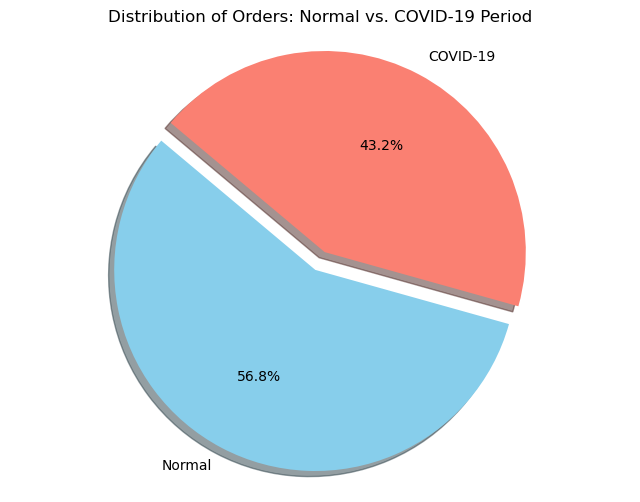

In [3]:
import matplotlib.pyplot as plt

# Assuming you have already created normal_df and covid_df

# Get the number of orders in each DataFrame
normal_count = len(normal_df)
covid_count = len(covid_df)

# Create a pie chart
labels = ['Normal', 'COVID-19']
sizes = [normal_count, covid_count]
colors = ['skyblue', 'salmon']
explode = (0, 0.1)  # explode the COVID-19 slice slightly
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Orders: Normal vs. COVID-19 Period')
plt.show()

The plot shows that the distribution between the Normal and COVID-19 periods is quite balanced, with both around 6.8% off from being equal. This suggests that there is no significant imbalance in the dataset, which is important for further research.

## Deeper looks at some columns

### Line delivery status
- Compared the ratio of different delivery statuses between normal and COVID-19 times.


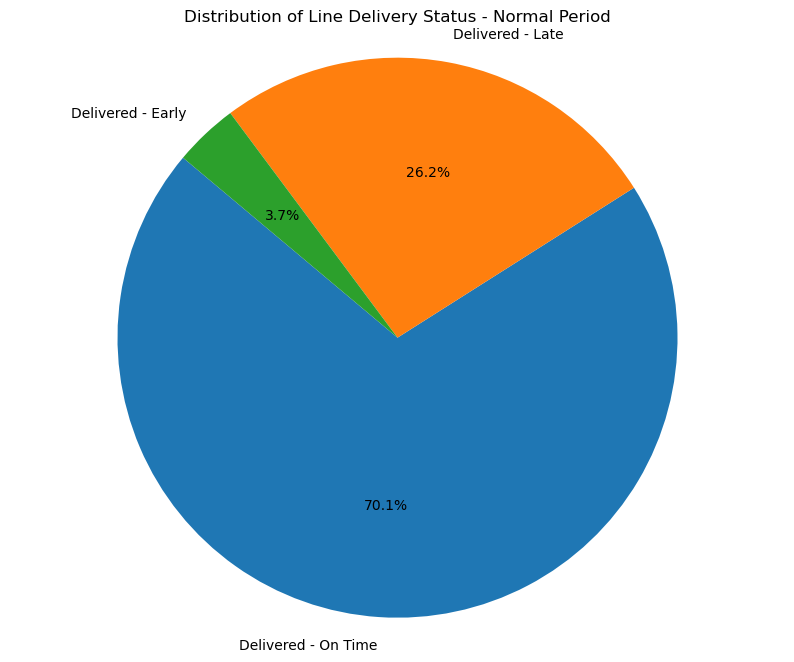

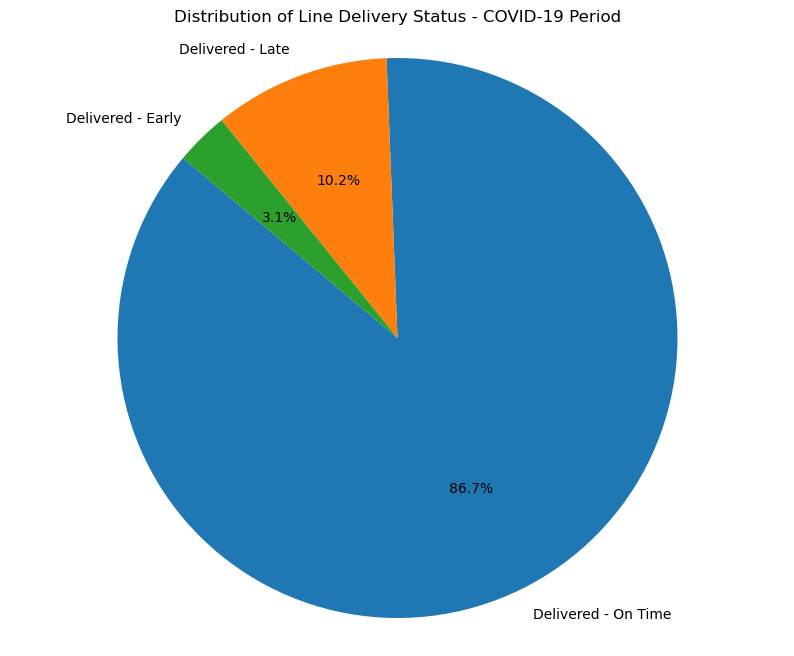

In [6]:

# Function to create a pie chart for a given dataframe
def create_pie_chart(df, title):
    # Get unique values and their counts
    value_counts = df['Line Delivery Status'].value_counts()

    # Create a pie chart
    plt.figure(figsize=(10, 8))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title(title)
    plt.show()

# Create pie chart for normal_df
create_pie_chart(normal_df, 'Distribution of Line Delivery Status - Normal Period')

# Create pie chart for covid_df
create_pie_chart(covid_df, 'Distribution of Line Delivery Status - COVID-19 Period')


The result is quite unexpected, as one might have assumed that the disruptions caused by the COVID-19 pandemic would lead to more late deliveries. However, it appears that the data suggests otherwise, indicating that delivery performance, at least on the surface, has improved during the COVID-19 period.

There could be several factors contributing to this unexpected finding. For example, during the pandemic, there might have been increased emphasis on efficiency and optimization of supply chains to overcome the challenges posed by lockdowns, travel restrictions, and other disruptions. Additionally, organizations may have implemented new strategies or technologies to enhance their delivery processes, such as improved inventory management systems or better coordination with suppliers and logistics partners.

It is also important to note that while the overall delivery performance may appear to be better during the COVID-19 period, there could still be specific cases or regions where delays have occurred due to the unique circumstances brought about by the pandemic. Further analysis and exploration of the data may reveal more insights into the factors influencing delivery performance during this challenging time.

### Look at the diffference between actual delivery time
The information can be look from "Deliver" which is the total time in days from order pickup to delivery

            Statistic      Normal    COVID-19
0                Mean   39.094830   38.096909
1                 Min -252.000000 -404.000000
2                 Max  639.000000  489.000000
3  Standard Deviation   45.190282   42.073450


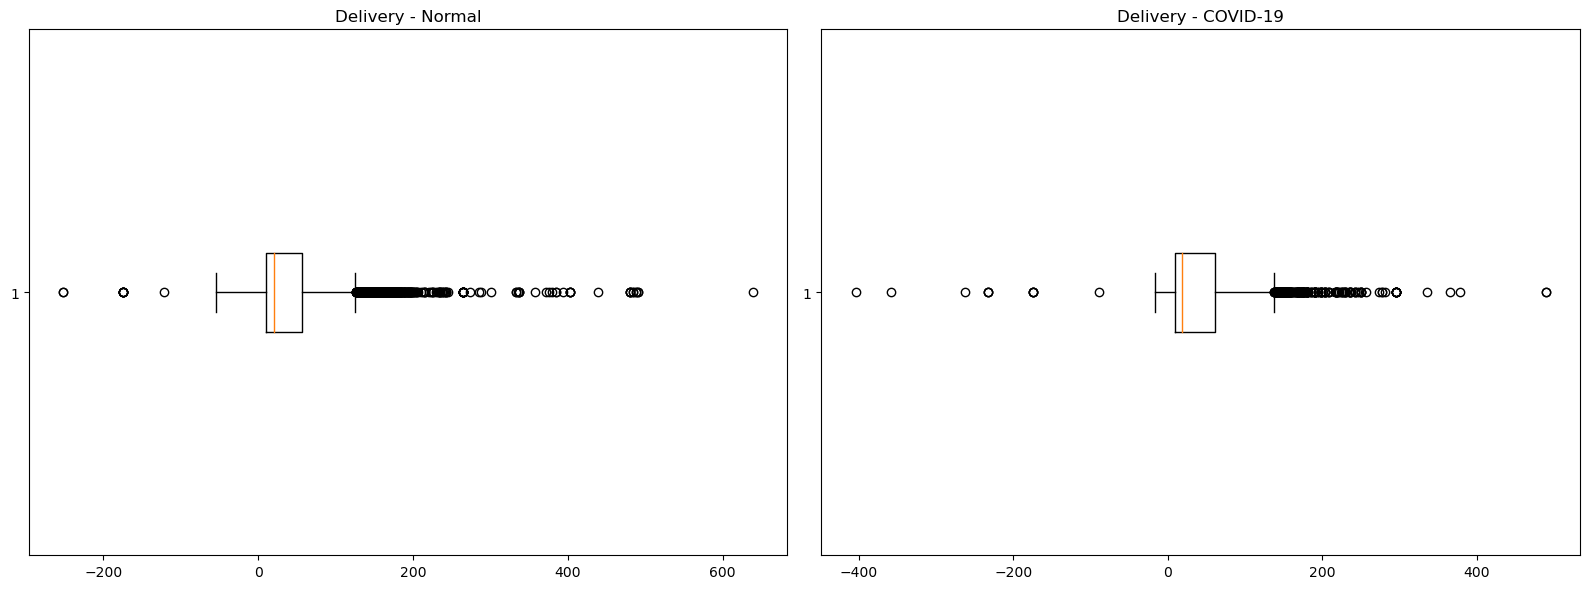

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Remove NaN values from 'Deliver' column
normal_delivery = normal_df['Deliver'].dropna()
covid_delivery = covid_df['Deliver'].dropna()

# Calculate mean, min, max, and standard deviation for normal_df
normal_mean = normal_delivery.mean()
normal_min = normal_delivery.min()
normal_max = normal_delivery.max()
normal_std = normal_delivery.std()

# Calculate mean, min, max, and standard deviation for covid_df
covid_mean = covid_delivery.mean()
covid_min = covid_delivery.min()
covid_max = covid_delivery.max()
covid_std = covid_delivery.std()

# Create a DataFrame to compare the results
comparison_df = pd.DataFrame({
    'Statistic': ['Mean', 'Min', 'Max', 'Standard Deviation'],
    'Normal': [normal_mean, normal_min, normal_max, normal_std],
    'COVID-19': [covid_mean, covid_min, covid_max, covid_std]
})

# Print the comparison table
print(comparison_df)



# Create a figure and axis
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Create a box plot for normal_df
ax[0].boxplot(normal_delivery, vert=False)
ax[0].set_title("Delivery - Normal")

# Create a box plot for covid_df
ax[1].boxplot(covid_delivery, vert=False)
ax[1].set_title("Delivery - COVID-19")

# Show the plot
plt.tight_layout()
plt.show()


Interestingly, the data suggests that delivery times during the COVID-19 period were slightly faster and more consistent compared to normal times. The average delivery time for COVID-19 orders was slightly lower, and there was also less variability in delivery times, as indicated by the lower standard deviation. This trend might be attributed to the global pandemic effort, where high-priority shipments were expedited to meet urgent healthcare needs. The data underscores the logistical adaptability and efficiency observed during times of crisis, reflecting the concerted efforts of supply chains to respond effectively to critical situations.

### Reason Code
Reason codes explain a change in the anticipated timing of a delivery. Acceptable delays (AD codes) are unforeseeable delays that are beyond GHSC-PSM’s manageable control. They are considered acceptable reasons to change the Agreed Delivery Date (ADD), with USAID mission or COR approval. Unacceptable delays (UD codes) are foreseeable or within GHSC-PSM’s manageable control. They are not valid reasons to change a delivery commitment (i.e. the ADD), but may be used when updating the Estimated Delivery Date (EDD). Supplier delays (SD codes) are an additional set of codes used to explain changes in supplier goods availability or delivery timelines.

Lets take a closer look at the Acceptable, unacceptable, and supplier delay.


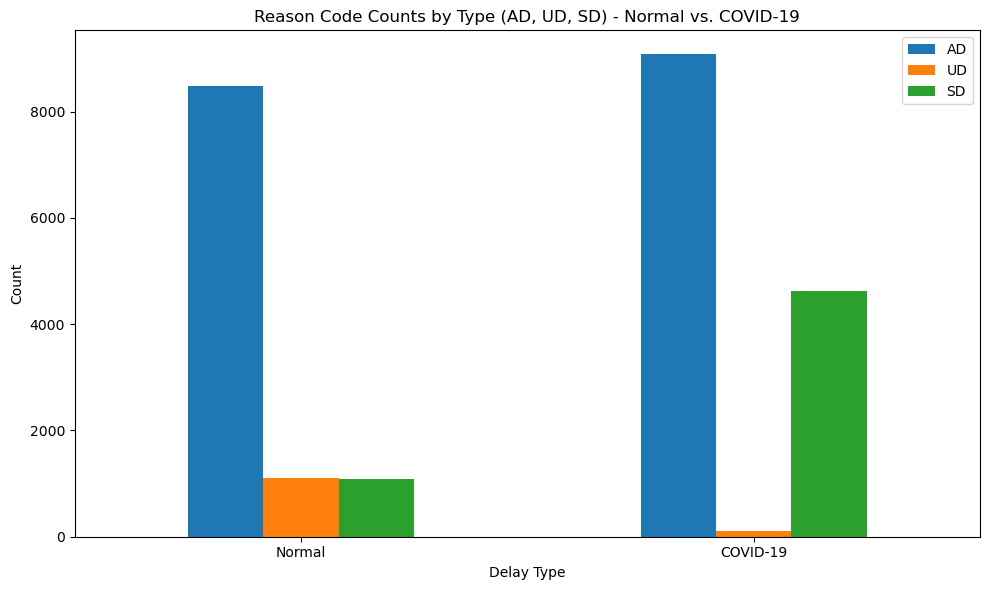

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract AD, UD, and SD codes from 'Reason Code' column
def extract_reason_code_counts(df):
    ad_count = df['Reason Code'].str.startswith('AD').sum()
    ud_count = df['Reason Code'].str.startswith('UD').sum()
    sd_count = df['Reason Code'].str.startswith('SD').sum()
    return ad_count, ud_count, sd_count

# Calculate counts for normal_df and covid_df
normal_ad_count, normal_ud_count, normal_sd_count = extract_reason_code_counts(normal_df.dropna(subset=['Reason Code']))
covid_ad_count, covid_ud_count, covid_sd_count = extract_reason_code_counts(covid_df.dropna(subset=['Reason Code']))

# Create a DataFrame for the counts
data = {
    'AD': [normal_ad_count, covid_ad_count],
    'UD': [normal_ud_count, covid_ud_count],
    'SD': [normal_sd_count, covid_sd_count]
}
counts_df = pd.DataFrame(data, index=['Normal', 'COVID-19'])

# Create a bar chart
ax = counts_df.plot(kind='bar', figsize=(10, 6))
ax.set_ylabel('Count')
ax.set_xlabel('Delay Type')
ax.set_title('Reason Code Counts by Type (AD, UD, SD) - Normal vs. COVID-19')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [24]:
import pandas as pd

# Function to calculate mean, min, max, and standard deviation for each reason code
def calculate_stats(df):
    ad_data = df[df['Reason Code'].str.startswith('AD')]['Reason Code'].str.extract('(\d+)')
    ud_data = df[df['Reason Code'].str.startswith('UD')]['Reason Code'].str.extract('(\d+)')
    sd_data = df[df['Reason Code'].str.startswith('SD')]['Reason Code'].str.extract('(\d+)')
    
    ad_stats = ad_data.astype(float).describe().dropna().apply(lambda x: round(x, 2))
    ud_stats = ud_data.astype(float).describe().dropna().apply(lambda x: round(x, 2))
    sd_stats = sd_data.astype(float).describe().dropna().apply(lambda x: round(x, 2))
    
    return ad_stats, ud_stats, sd_stats

# Calculate stats for normal_df and covid_df
normal_ad_stats, normal_ud_stats, normal_sd_stats = calculate_stats(normal_df.dropna(subset=['Reason Code']))
covid_ad_stats, covid_ud_stats, covid_sd_stats = calculate_stats(covid_df.dropna(subset=['Reason Code']))

# Create a DataFrame for the stats
stats_df = pd.concat([normal_ad_stats, covid_ad_stats, normal_ud_stats, covid_ud_stats, normal_sd_stats, covid_sd_stats], axis=1)
stats_df.columns = ['Normal AD', 'COVID-19 AD', 'Normal UD', 'COVID-19 UD', 'Normal SD', 'COVID-19 SD']

# Output the stats DataFrame
print(stats_df)


       Normal AD  COVID-19 AD  Normal UD  COVID-19 UD  Normal SD  COVID-19 SD
count    8484.00      9077.00    1108.00       110.00    1088.00      4629.00
mean       90.02        54.65     112.30       306.27       9.14         4.53
std       256.18       168.07     275.23       412.87       9.03         7.17
min        10.00        10.00       0.00        20.00       0.00         0.00
25%        12.00        12.00       0.00        40.00       0.00         0.00
50%        12.00        12.00      40.00        50.00       5.00         0.00
75%        12.00        50.00      40.00       990.00      20.00         5.00
max       999.00       999.00     990.00       990.00      22.00        25.00


This table demonstrates a significant difference between the normal and COVID-19 periods in terms of delays represented by the reason codes.

- **Acceptable Delays (AD):** The count of AD codes during COVID-19 is lower than in the normal period, indicating that there were fewer delays considered acceptable during COVID-19. The mean and standard deviation also show a decrease, suggesting that the delays during COVID-19 were more consistent but generally shorter compared to the normal period.

- **Unacceptable Delays (UD):** The count, mean, and standard deviation of UD codes during COVID-19 are higher than in the normal period. This indicates that there were more delays considered unacceptable during COVID-19, and these delays were more variable in length compared to the normal period.

- **Supplier Delays (SD):** The count of SD codes during COVID-19 is higher than in the normal period, indicating more delays caused by suppliers. However, the mean and standard deviation show a decrease, suggesting that these delays were more consistent but generally shorter compared to the normal period.

Overall, this table highlights the challenges faced during COVID-19, with an increase in delays considered unacceptable and caused by suppliers, impacting the delivery timelines.
